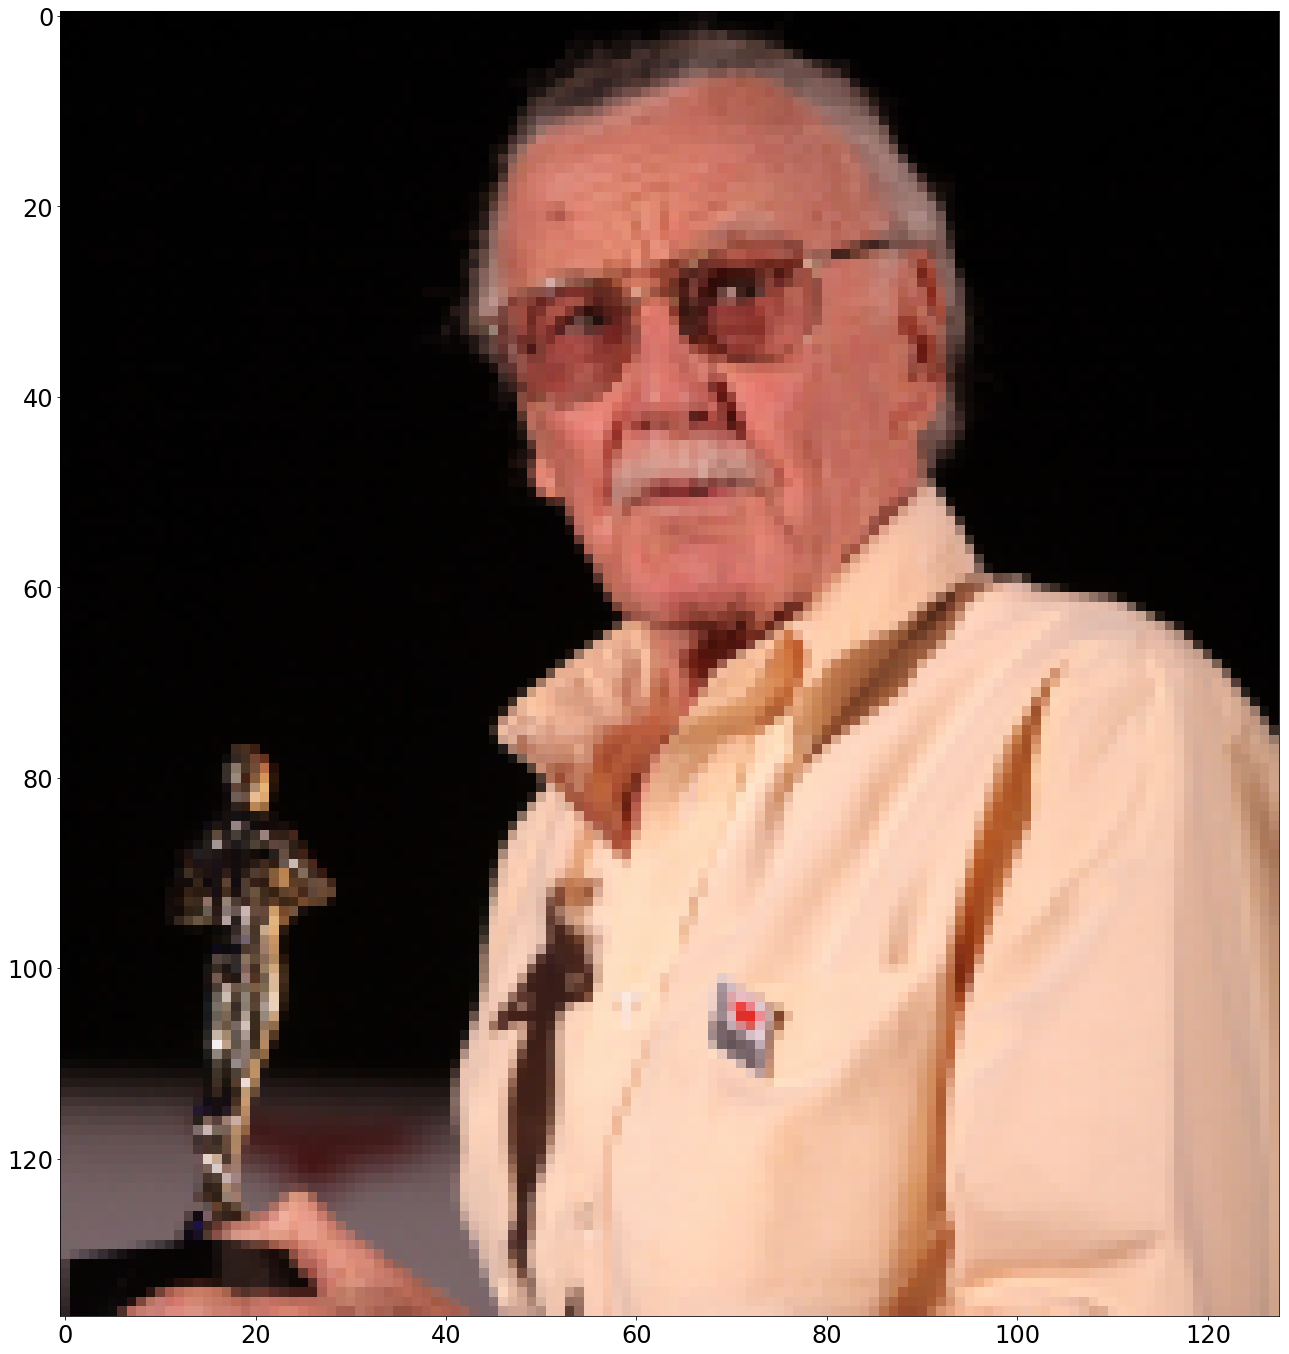

In [76]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from imageio import imread

pylab.rcParams['figure.figsize'] = (24.0, 24.0)
pylab.rcParams['font.size'] = 24

im = imread('Graphics/origin.png')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im)
plt.show()

In [10]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1, N-1)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2, N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        
        return n
    if size==8:
        n = [(i-1, j), (i-1, j-1), (i-1, j+1), (i, j-1), (i, j+1), (i+1, j), (i+1,j-1), (i+1,j+1)]
        n = [(x, y) for (x, y) in n if 0 <= x <= M - 1 and 0 <= y <= N - 1]
        return n

In [37]:
def p(yi, ground, m):
    n = np.sum(ground)
    if n == 0:
        return 0
    p = int(np.floor(np.linalg.norm(yi/255)/math.sqrt(3) * m))
    return ground[p]/n

In [38]:
def bins(x0, i, j, y, foreground, background, d, m):
    p = int(np.floor(np.linalg.norm(y[i, j]/255)/math.sqrt(3) * m))
    if x0[i, j] == 1:
        foreground[p] += d
    else:
        background[p] += d

In [39]:
def gibbs_sampling(x0, y, m, T, M, N, beta):
    x = x0
    
    foreground = np.zeros(m)
    background = np.zeros(m)
    
    for i in range(0, M):
        for j in range(0, N):
            bins(x, i, j, y, foreground, background, 1, m)
                
    for t in range(0, T):        
        for i in range(0, M):
            for j in range(0, N):
                pp = p(y[i][j], foreground, m) + beta * np.sum([x[a][b] for (a, b) in neighbours(i, j, M, N, size = 8)])
                
                pn = p(y[i][j], background, m) + beta * np.sum([-x[a][b] for (a, b) in neighbours(i, j, M, N, size = 8)])
                
                q = pp / (pp + pn)
                
                if q > np.random.uniform():
                    bins(x, i, j, y, foreground, background, -1, m)
                    x[i,j] = 1                    
                    bins(x, i, j, y, foreground, background, 1, m)
                else:
                    bins(x, i, j, y, foreground, background, -1, m)
                    x[i,j] = -1
                    bins(x, i, j, y, foreground, background, 1, m)
        
    return x

In [119]:
(M, N, _) = im.shape
out = gibbs_sampling(2*np.random.binomial(1,0.5, (M, N))-1, im, 10, 5, M, N, 0.09)

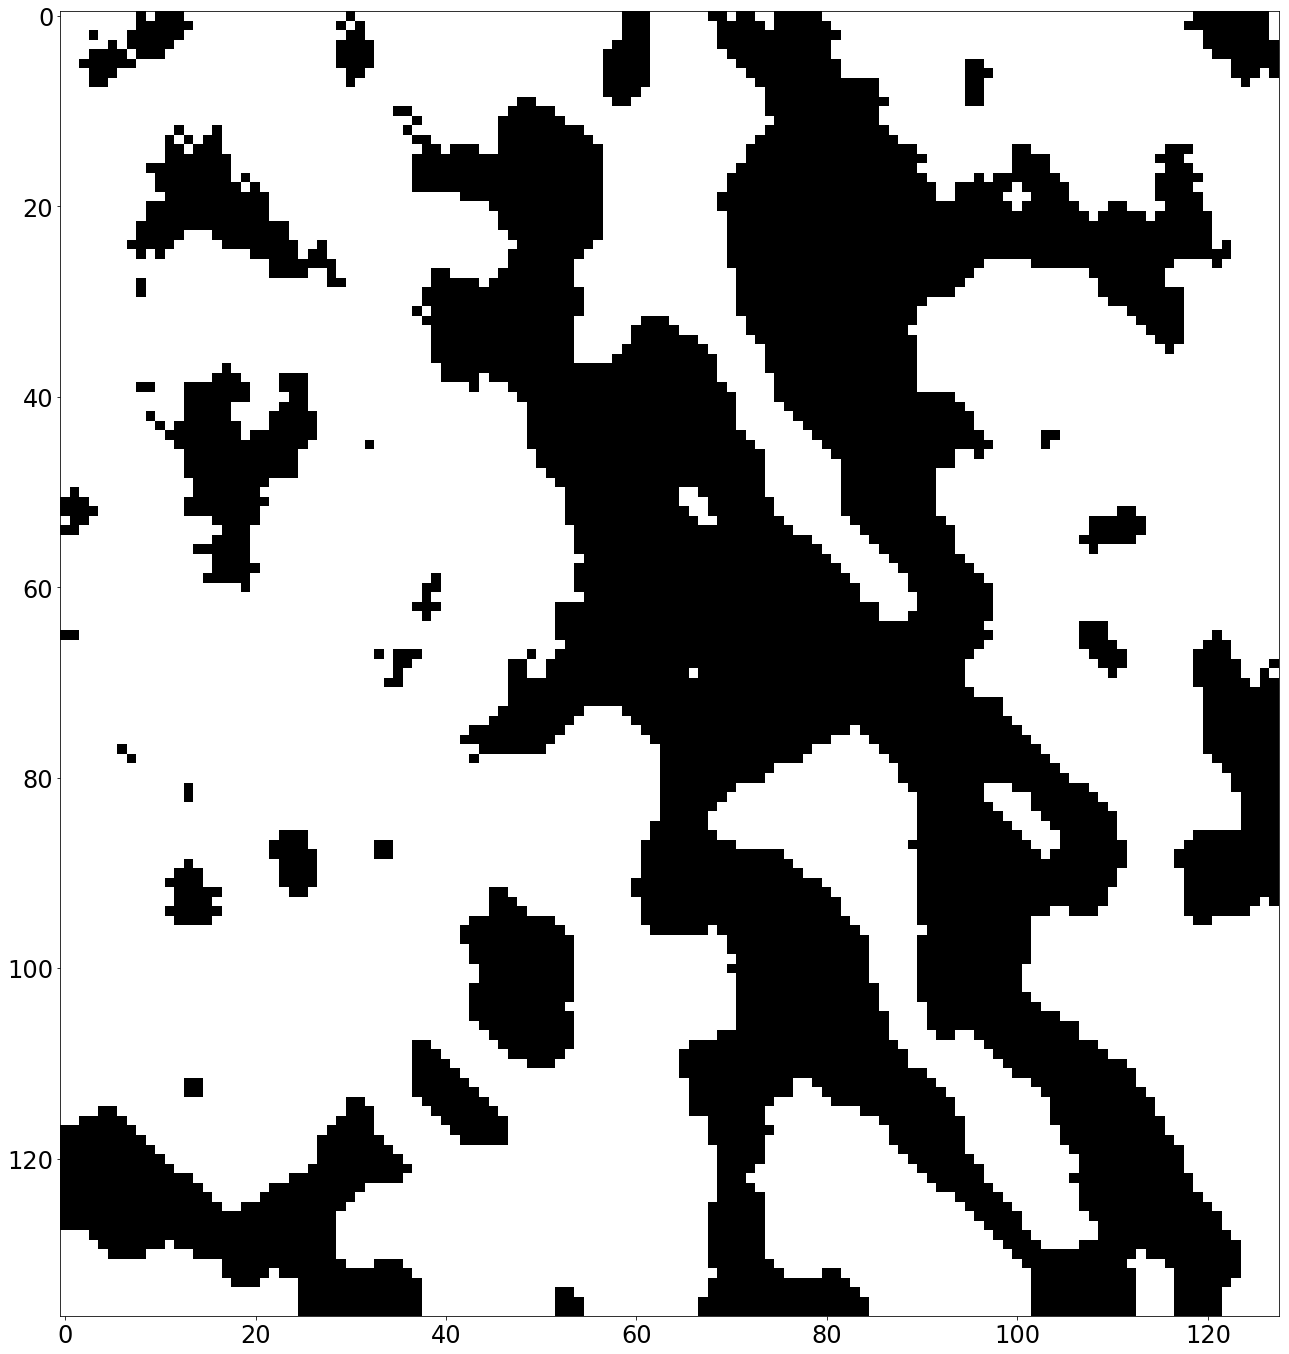

In [120]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(out, cmap='gray')
plt.show()

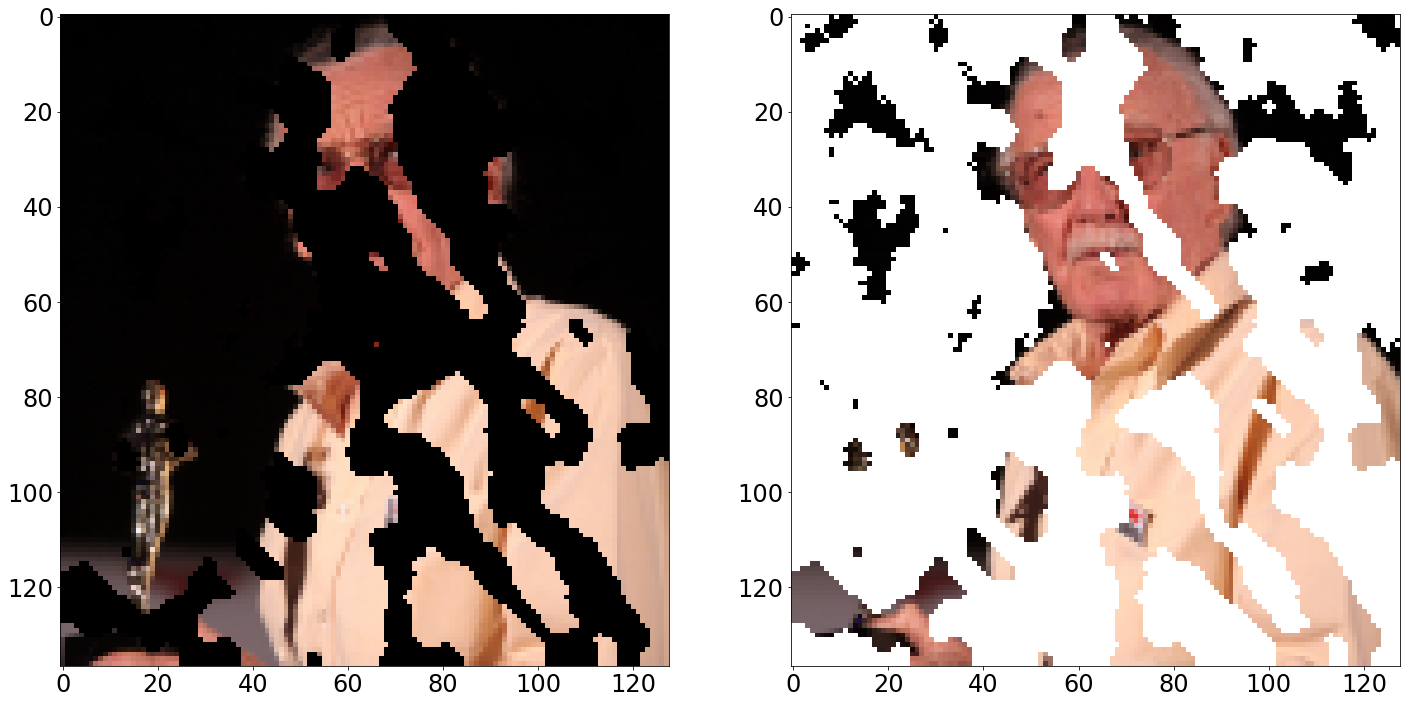

In [121]:
foreground = np.array(im)
background = np.array(im)
for i in range(0, M):
    for j in range(0, N):
        if out[i,j] == -1:
            foreground[i,j] = [0, 0, 0]
        else:
            background[i,j] = [255, 255, 255]


fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(foreground)

ax2 = fig.add_subplot(122)
ax2.imshow(background)
plt.show()